In [1]:
import numpy as np
from scipy.linalg import expm

# Define Pauli matrices for convenience
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

# Define Hamiltonians H_A and H_B (acting on two qubits)
H_A = np.kron(X, I) + np.kron(I, X)  # Example interaction along X axis
H_B = np.kron(Z, I) + np.kron(I, Z)  # Example interaction along Z axis

# Trotterized time evolution for time t with N steps
def trotter_evolution(H_A, H_B, t, N):
    dt = t / N  # Time step
    U_A = expm(-1j * H_A * dt)  # Evolution operator for H_A
    U_B = expm(-1j * H_B * dt)  # Evolution operator for H_B
    
    U_total = np.eye(4, dtype=complex)  # Identity matrix for 2-qubit system
    for _ in range(N):
        U_total = U_B @ U_A @ U_total  # Apply U_A and U_B alternately
    
    return U_total

# Parameters
t = 1.0  # Total evolution time
N = 10   # Number of Trotter steps

# Perform Trotterized evolution
U_trotter = trotter_evolution(H_A, H_B, t, N)

# Print the result
print("Trotterized time evolution operator:\n", U_trotter)


Trotterized time evolution operator:
 [[-0.46053246-2.18877221e-01j -0.49619641-6.07546302e-02j
  -0.49619641-6.07546302e-02j -0.48033123+9.73679610e-02j]
 [-0.47423544-1.58122591e-01j  0.50989939+6.62455034e-17j
  -0.49010061+3.84899278e-17j  0.47423544-1.58122591e-01j]
 [-0.47423544-1.58122591e-01j -0.49010061+6.66030586e-17j
   0.50989939+3.19085891e-17j  0.47423544-1.58122591e-01j]
 [-0.48033123-9.73679610e-02j  0.49619641-6.07546302e-02j
   0.49619641-6.07546302e-02j -0.46053246+2.18877221e-01j]]


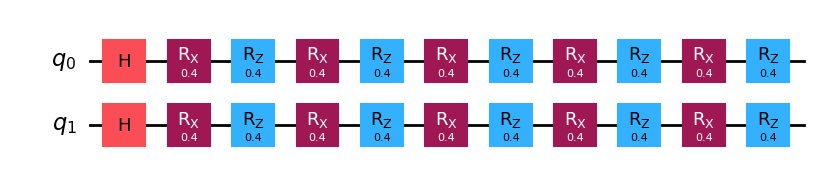

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate
import numpy as np

%matplotlib inline

# Define the time evolution and trotter step function
def trotter_step(qc, delta_t, H_A_gate, H_B_gate):
    # Apply evolution under H_A (Pauli-X terms)
    qc.append(H_A_gate, [0])
    qc.append(H_A_gate, [1])
    
    # Apply evolution under H_B (Pauli-Z terms)
    qc.append(H_B_gate, [0])
    qc.append(H_B_gate, [1])

# Parameters
t = 1.0  # Total evolution time
N = 5    # Number of Trotter steps
delta_t = t / N

# Create a quantum circuit for 2 qubits
qc = QuantumCircuit(2)

# Initialize the qubits in the |+⟩ state (superposition)
qc.h(0)
qc.h(1)

# Trotterization evolution
for _ in range(N):
    # Apply RX and RZ gates for time evolution (acting as H_A and H_B)
    trotter_step(qc, delta_t, RXGate(2 * delta_t), RZGate(2 * delta_t))
    
qc.draw(output='mpl')

Operator([[-0.32682181+3.78401248e-01j, -0.32682181+3.78401248e-01j,
           -0.32682181+3.78401248e-01j, -0.32682181+3.78401248e-01j],
          [ 0.5       +6.93889390e-17j, -0.5       -1.80411242e-16j,
            0.5       +6.93889390e-17j, -0.5       -1.80411242e-16j],
          [ 0.3607563 -1.26458865e-01j,  0.20059813+5.60020926e-01j,
           -0.3607563 +1.26458865e-01j, -0.20059813-5.60020926e-01j],
          [-0.55494493+2.14240937e-01j,  0.14010167+3.55680296e-01j,
            0.55494493-2.14240937e-01j, -0.14010167-3.55680296e-01j]],
         input_dims=(2, 2), output_dims=(2, 2))
Total number of gates in the circuit: 62


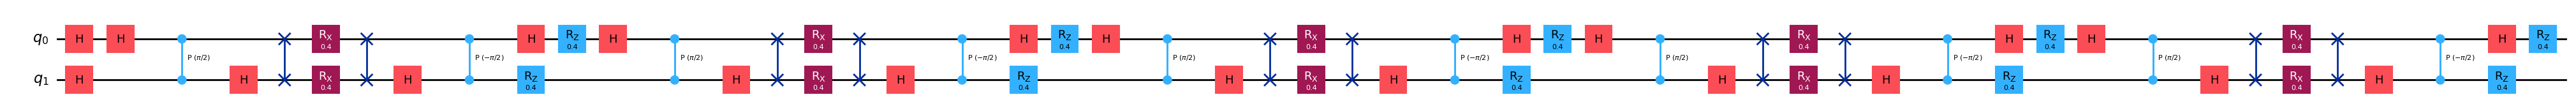

In [40]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
import numpy as np

# Define the Quantum Fourier Transform (QFT) for 2 qubits
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2**(j - i), i, j)
    # Apply swap gates to reverse the qubit order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)

# Define the Inverse Quantum Fourier Transform (QFT†)
def inverse_qft(qc, n):
    # Apply the QFT gates in reverse order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            qc.cp(-np.pi / 2**(j - i), i, j)
        qc.h(i)

# Define the time evolution and trotter step function for kinetic and potential energy
def trotter_step(qc, delta_t, kinetic_gate, potential_gate):
    # Apply the QFT to go to momentum space
    qft(qc, 2)
    
    # Apply evolution under kinetic energy (momentum-related term)
    qc.append(kinetic_gate, [0])  # On qubit 0
    qc.append(kinetic_gate, [1])  # On qubit 1

    # Apply the inverse QFT to go back to position space
    inverse_qft(qc, 2)

    # Apply evolution under potential energy (position-related term)
    qc.append(potential_gate, [0])  # On qubit 0
    qc.append(potential_gate, [1])  # On qubit 1

# Parameters
t = 1.0  # Total evolution time
N = 5    # Number of Trotter steps
delta_t = t / N

# Create a quantum circuit for 2 qubits
qc = QuantumCircuit(2)

# Initialize the qubits in the |+⟩ state (superposition)
qc.h(0)
qc.h(1)

# Trotterization evolution
for _ in range(N):
    # Apply RX for kinetic energy and RZ for potential energy, including QFT and QFT†
    trotter_step(qc, delta_t, RXGate(2 * delta_t), RZGate(2 * delta_t))

print(Operator(qc)) # unitary

# Count the number of gates in the circuit
gate_counts = qc.count_ops()

# Print the gate counts
#print("Gate counts:", gate_counts)

# Calculate the total number of gates
total_gates = sum(gate_counts.values())
print("Total number of gates in the circuit:", total_gates)

qc.draw(output='mpl', fold=-1)


In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
import numpy as np

# Define the Quantum Fourier Transform (QFT) for 2 qubits
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2**(j - i), i, j)
    # Apply swap gates to reverse the qubit order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)

# Define the Inverse Quantum Fourier Transform (QFT†)
def inverse_qft(qc, n):
    # Apply the QFT gates in reverse order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            qc.cp(-np.pi / 2**(j - i), i, j)
        qc.h(i)

# Rewriting R_x using R_y gates
def rx_as_ry(qc, theta, qubit):
    qc.ry(np.pi / 2, qubit)  # Rotate from x-axis to z-axis
    qc.ry(theta, qubit)      # Apply rotation around y-axis
    qc.ry(-np.pi / 2, qubit) # Rotate back from z-axis to x-axis

# Rewriting R_z using R_y gates
def rz_as_ry(qc, theta, qubit):
    qc.ry(np.pi / 2, qubit)  # Rotate from z-axis to y-axis
    qc.rz(theta, qubit)      # Apply rotation around z-axis (can also rewrite)
    qc.ry(-np.pi / 2, qubit) # Rotate back from y-axis to z-axis

# Define the time evolution and trotter step function for kinetic and potential energy
def trotter_step(qc, delta_t, qubits):
    # Apply the QFT to go to momentum space
    qft(qc, len(qubits))
    
    # Apply evolution under kinetic energy, originally Rx but using Ry
    for qubit in qubits:
        rx_as_ry(qc, 2 * delta_t, qubit)

    # Apply the inverse QFT to go back to position space
    inverse_qft(qc, len(qubits))

    # Apply evolution under potential energy, originally Rz but using Ry
    for qubit in qubits:
        rz_as_ry(qc, 2 * delta_t, qubit)

# Parameters
t = 1.0  # Total evolution time
N = 5    # Number of Trotter steps
delta_t = t / N

# Create a quantum circuit for 2 qubits
qc = QuantumCircuit(2)

# Initialize the qubits in the |+⟩ state (superposition)
qc.h(0)
qc.h(1)

# Trotterization evolution using Ry decompositions for Rx and Rz
for _ in range(N):
    trotter_step(qc, delta_t, [0, 1])

print(Operator(qc)) # unitary

qc.draw(output='mpl', fold=-1)

# Count the number of gates in the circuit
gate_counts = qc.count_ops()

# Print the gate counts
#print("Gate counts:", gate_counts)

# Calculate the total number of gates
total_gates = sum(gate_counts.values())
print("Total number of gates in the circuit:", total_gates)

Operator([[ 0.10960111+0.55940243j,  0.37185284+0.09247811j,
            0.01442103-0.20169174j, -0.60282485+0.35205745j],
          [-0.38593593+0.2503041j , -0.16628894-0.33229101j,
            0.57454208-0.42102617j,  0.29862086+0.23193951j],
          [-0.13389542+0.3031169j ,  0.69268787+0.18816673j,
           -0.04265552+0.14292086j,  0.5729676 -0.15630488j],
          [-0.42354954-0.41743955j,  0.35589093-0.27059634j,
           -0.44539327-0.48075962j, -0.12978935+0.01090993j]],
         input_dims=(2, 2), output_dims=(2, 2))
Total number of gates in the circuit: 102


In [37]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import Operator, Statevector, DensityMatrix
import numpy as np

# Define the Quantum Fourier Transform (QFT) for 2 qubits
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2**(j - i), i, j)
    # Apply swap gates to reverse the qubit order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)

# Define the Inverse Quantum Fourier Transform (QFT†)
def inverse_qft(qc, n):
    # Apply the QFT gates in reverse order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            qc.cp(-np.pi / 2**(j - i), i, j)
        qc.h(i)

# Rewriting Rx using Rz and Hadamard gates
def rx_as_rz(qc, theta, qubit):
    qc.h(qubit)          # Apply Hadamard to rotate the Bloch sphere
    qc.rz(theta, qubit)  # Apply Rz (effectively Rx after the Hadamard)
    qc.h(qubit)          # Apply Hadamard to rotate back

# Define the time evolution and trotter step function for kinetic and potential energy
def trotter_step(qc, delta_t, qubits):
    # Apply the QFT to go to momentum space
    qft(qc, len(qubits))
    
    # Apply evolution under kinetic energy, originally Rx but using Rz
    for qubit in qubits:
        rx_as_rz(qc, 2 * delta_t, qubit)

    # Apply the inverse QFT to go back to position space
    inverse_qft(qc, len(qubits))

    # Apply evolution under potential energy, use Rz directly
    for qubit in qubits:
        qc.rz(2 * delta_t, qubit)

# Parameters
t = 1.0  # Total evolution time
N = 5    # Number of Trotter steps
delta_t = t / N

# Create a quantum circuit for 2 qubits
qc = QuantumCircuit(2)

# Initialize the qubits in the |+⟩ state (superposition)
qc.h(0)
qc.h(1)

# Trotterization evolution using Rz decomposition for Rx
for _ in range(N):
    trotter_step(qc, delta_t, [0, 1])
    
# Create a quantum circuit for 2 qubits
qc = QuantumCircuit(2)

# Initialize the qubits in the |+⟩ state (superposition)
qc.h(0)
qc.h(1)

# Trotterization evolution using Ry decompositions for Rx and Rz
for _ in range(N):
    trotter_step(qc, delta_t, [0, 1])

print(Operator(qc)) # unitary

qc.draw(output='mpl', fold=-1)

# Count the number of gates in the circuit
gate_counts = qc.count_ops()

# Print the gate counts
#print("Gate counts:", gate_counts)

# Calculate the total number of gates
total_gates = sum(gate_counts.values())
print("Total number of gates in the circuit:", total_gates)


Operator([[-0.32682181+3.78401248e-01j, -0.32682181+3.78401248e-01j,
           -0.32682181+3.78401248e-01j, -0.32682181+3.78401248e-01j],
          [ 0.5       +6.93889390e-17j, -0.5       +5.55111512e-17j,
            0.5       +6.93889390e-17j, -0.5       +5.55111512e-17j],
          [ 0.3607563 -1.26458865e-01j,  0.20059813+5.60020926e-01j,
           -0.3607563 +1.26458865e-01j, -0.20059813-5.60020926e-01j],
          [-0.55494493+2.14240937e-01j,  0.14010167+3.55680296e-01j,
            0.55494493-2.14240937e-01j, -0.14010167-3.55680296e-01j]],
         input_dims=(2, 2), output_dims=(2, 2))
Gate counts: OrderedDict([('h', 42), ('rz', 20), ('cp', 10), ('swap', 10)])
Total number of gates in the circuit: 82
